## Table des matières

- [Présentation des données](#Intro)
- [1. Correction des données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire](#chapitre_1)
- [2. Désaisonnalisation de la consommation obtenue après correction, grâce aux moyennes mobiles](#chapitre_2)
- [3. Prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temportelle](#chapitre_3)

In [1]:
import numpy as np
import pandas as pd

<a id="Intro"></a>
## <span style="color: #030aa4">Présentation des données</span>

Les données mensuelles de consommation d'électricité en énergie proviennent du site https://www.rte-france.com/eco2mix/telecharger-les-indicateurs

In [19]:
DonneesMensuelles = pd.read_csv("eCO2mix_RTE_energie_M.csv", sep='\t')

DonneesMensuelles.head(3)

,Mois,Qualite,Territoire,Production totale,Production nucleaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioenergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,Donnees definitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,Donnees definitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,Donnees definitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0


In [16]:
DonneesMensuelles.columns

Index(['Mois', 'Qualite', 'Territoire', 'Production totale',
       'Production nucleaire', 'Production thermique totale',
       'Production thermique charbon', 'Production thermique fioul',
       'Production thermique gaz', 'Production hydraulique',
       'Production eolien', 'Production solaire', 'Production bioenergies',
       'Consommation totale', 'Solde exportateur', 'Echanges export',
       'Echanges import', 'Echanges avec le Royaume-Uni',
       'Echanges avec l'Espagne', 'Echanges avec l'Italie',
       'Echanges avec la Suisse', 'Echanges avec l'Allemagne et la Belgique'],
      dtype='object')

Le dataframe se compose de 22 colonnes :
- Mois : indique le mois analysé
- Qualite : trois types de données : temps réel, consolidées et définitives. Données temps réel disponibles 30 jours, puis remplacées par données consolidées. Données consolidées remplacées par donées définitives l'année suivante
- Territoire : indique le territoire concerné. Choix entre la France et une des 12 régions administratives.
- Production totale :  production totale d'électricité en MW
- Production nucléaire/thermique totale/thermique charbon/thermique fioul/thermique gaz/hydraulique/eolien/solaire/bioenergies : indique la quantité de production d'électricité produite en MW selon la source de production 
- Consommation totale : consommation totale d'électricité en MW
- Solde exportateur : somme des quantités d'électricité en MW importées et exportées
- Echanges exports : quantité d'électricité en MW exportée
- Echanges imports : quantité d'électricité en MW importée
- Echanges avec R-U/Espagne/Italie/Suisse/Allemagne et Belgique : détails des échanges avec chaque pays indiqué

Source des informations : https://assets.rte-france.com/prod/public/2020-07/%C3%A9CO2mix%20-%20Description%20des%20fichiers%20des%20donn%C3%A9es%20en%20puissance.pdf

Les données de l'effet température proviennent du site https://cegibat.grdf.fr/simulateur/calcul-dju 

In [39]:
Dju_chauffage = pd.read_csv('dju_chauffage.csv')

Dju_chauffage

,Unnamed: 0,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,TOTAL
0,2010,624.8,474.7,414.9,292.7,260.6,112.6,46.5,93.8,163.6,286.4,419.3,644.1,3833.8
1,2011,507.2,408.6,368.7,202.0,165.6,117.2,122.5,84.7,101.9,232.3,338.0,424.8,3073.4
2,2012,454.5,555.6,334.9,344.4,192.8,133.3,95.3,59.6,165.5,262.1,403.3,455.7,3456.9
3,2013,548.2,519.7,505.5,326.3,277.4,146.0,51.3,79.0,141.8,209.3,417.7,456.5,3678.6
4,2014,434.4,376.9,346.9,255.1,219.7,124.4,76.3,104.9,111.9,194.5,326.6,489.2,3060.6
5,2015,507.0,472.3,400.2,269.9,210.1,109.2,62.7,61.0,184.6,293.5,301.0,349.1,3220.5
6,2016,477.6,428.8,445.1,333.6,207.6,117.4,66.3,61.3,85.7,290.2,400.3,511.6,3425.4
7,2017,592.6,382.6,318.9,315.3,168.7,72.8,59.2,74.7,158.1,206.1,392.9,483.4,3225.2
8,2018,417.9,537.6,426.6,224.3,163.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


Le jeu de données 'Dju_chauffage' est composée de 14 colonnes et 9 lignes. 12 de ces colonnes indiquent le degré jour unifié pour chaque mois de l'année. la première colonne nous indique l'année concernée et la dernière le total annuel. Chaque ligne correspond à une année pour la période allant de 2010 à 2018.

Le degré jour est une valeur représentative de l’écart entre la température d’une journée donnée et un seuil de température préétabli (18 °C dans le cas des DJU ou Degré Jour Unifié). Sommés sur une période, ils permettent de calculer les besoins de chauffage d’un bâtiment.
    
Source : https://cegibat.grdf.fr/simulateur/calcul-dju

<a id="chapitre_1"></a>
## <span style="color: #030aa4">1. Correction des données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire</span>

In [69]:
data = DonneesMensuelles.loc[:,('Mois','Territoire','Consommation totale')]
data = data[data.Territoire=='France']
data = data.rename(columns={'Consommation totale':'consommation_totale_France'})\
           .drop(columns='Territoire')

data['Mois'] = pd.to_datetime(data['Mois'], infer_datetime_format=True)

data_chauffage = Dju_chauffage[Dju_chauffage['Unnamed: 0']!=2010]
data_chauffage = data_chauffage[data_chauffage['Unnamed: 0']!=2011]
data_chauffage = data_chauffage.drop(columns='TOTAL')\
                               .rename(columns={'JAN':'01','FÉV':'02','MAR':'03','AVR':'04','MAI':'05','JUN':'06','JUI':'07','AOÛ':'08','SEP':'09','OCT':'10','NOV':'11','DÉC':'12'})\
                               .melt('Unnamed: 0', var_name= 'Année', value_name='DJU')\
                               .rename(columns={'Unnamed: 0':'year','Année':'month'})

data_chauffage['Mois'] = pd.to_datetime(data_chauffage[['year', 'month']].assign(DAY=1))

data_chauffage = data_chauffage.drop(columns=['year','month'])

data = pd.merge(data,data_chauffage)

data

,Mois,consommation_totale_France,DJU
0,2012-01-01,51086,454.5
1,2012-02-01,54476,555.6
2,2012-03-01,43156,334.9
3,2012-04-01,40176,344.4
4,2012-05-01,35257,192.8
...,...,...,...
79,2018-08-01,32451,0.0
80,2018-09-01,32683,0.0
81,2018-10-01,37102,0.0
82,2018-11-01,43738,0.0


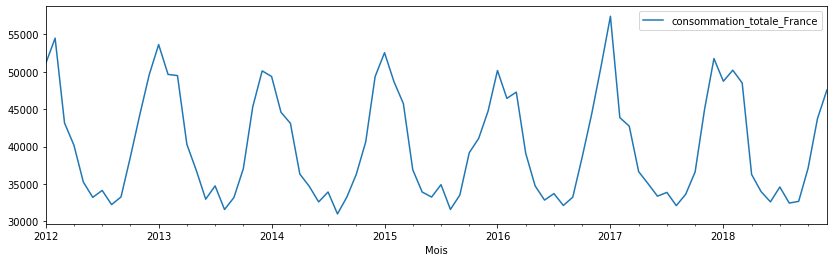

In [67]:
data.plot(x='Mois',y="consommation_totale_France", figsize=(14,4))

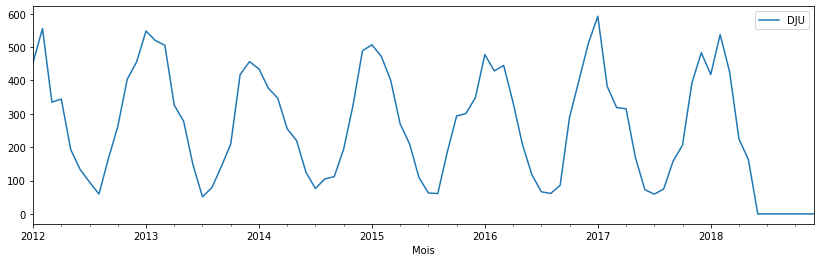

In [68]:
data.plot(x='Mois',y="DJU", figsize=(14,4))

In [73]:
DjuArray = Dju_chauffage[Dju_chauffage['Unnamed: 0']!=2010]
DjuArray = DjuArray[DjuArray['Unnamed: 0']!=2011]
DjuArray = DjuArray.drop(columns=['Unnamed: 0','TOTAL'])
DjuArray = DjuArray.values

DjuArray

array([[454.5, 555.6, 334.9, 344.4, 192.8, 133.3,  95.3,  59.6, 165.5,
        262.1, 403.3, 455.7],
       [548.2, 519.7, 505.5, 326.3, 277.4, 146. ,  51.3,  79. , 141.8,
        209.3, 417.7, 456.5],
       [434.4, 376.9, 346.9, 255.1, 219.7, 124.4,  76.3, 104.9, 111.9,
        194.5, 326.6, 489.2],
       [507. , 472.3, 400.2, 269.9, 210.1, 109.2,  62.7,  61. , 184.6,
        293.5, 301. , 349.1],
       [477.6, 428.8, 445.1, 333.6, 207.6, 117.4,  66.3,  61.3,  85.7,
        290.2, 400.3, 511.6],
       [592.6, 382.6, 318.9, 315.3, 168.7,  72.8,  59.2,  74.7, 158.1,
        206.1, 392.9, 483.4],
       [417.9, 537.6, 426.6, 224.3, 163. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ]])

In [74]:
data =data.drop(columns='DJU')

data

,Mois,consommation_totale_France
0,2012-01-01,51086
1,2012-02-01,54476
2,2012-03-01,43156
3,2012-04-01,40176
4,2012-05-01,35257
...,...,...
79,2018-08-01,32451
80,2018-09-01,32683
81,2018-10-01,37102
82,2018-11-01,43738


In [75]:
from sklearn import linear_model

reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(DjuArray.transpose(), data)

TypeError: invalid type promotion

<a id="chapitre_2"></a>
## <span style="color: #030aa4">2. Désaisonnalisation de la consommation obtenue après correction, grâce aux moyennes mobiles</span>

<a id="chapitre_3"></a>
## <span style="color: #030aa4">3. Prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temportelle</span>